### PyWren RISECamp, 2017

In [44]:
%pylab inline
import boto3
import cloudpickle
import itertools
import concurrent.futures as fs
import io
import numpy as np
import time
from importlib import reload
from sklearn import metrics
import pywren
import pywren.wrenconfig as wc
import itertools

Populating the interactive namespace from numpy and matplotlib


/Users/vaishaal/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['matrix']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [17]:
DEFAULT_BUCKET = wc.default()['s3']['bucket']


## 1. Matrix Multiplication

One nice thing about PyWren is it allows users to integrate existing python libraries easily.
For the following exercise, we are going to use some popular python libraries, e.g., NumPy, to work on some matrix multiplication problems.

In [5]:
import numpy as np

def my_function(b):
    x = np.random.normal(0, b, 1024)
    A = np.random.normal(0, b, (1024, 1024))
    return np.dot(A, x)

pwex = pywren.default_executor()
res = pwex.map(my_function, np.linspace(0.1, 10, 100))


array([ 0.02155827,  0.26961813,  0.42765298, ...,  0.20587824,
       -0.61549094, -0.39917608])

## 2. Large Scale Matrix Multiplication

A problem with the above method is that, we are limited to working with "small" matrices, that fit in the memory of a single lambda instance. With a little work we can write a "ShardedMatrix" wrapper that shards numpy matrices across S3 objects. This allows us to use PyWren's map functionality to access different parts of the matrix. We can further use this functionality to compute a large scale matrix multiplication.

In [19]:
from sklearn.datasets import fetch_mldata
import matrix
reload(matrix)

<module 'matrix' from '/Users/vaishaal/research/risecamp/pywren/matrix.py'>

Lets download the mnist dataset. This cell should take about 3 minutes to complete.

In [20]:
X = fetch_mldata('MNIST original', data_home="/tmp/")['data'].astype('float32')
y = fetch_mldata('MNIST original', data_home="/tmp/")['target']
X_train = X[:60000, :]
y_train = y[:60000, np.newaxis]

X_test = X[60000:, :]
y_test = y[60000:, np.newaxis]

We will now "shard" the mnist matrix with a shard_size of 4000, what this means is that, we will convert the 60000 by 784 matrix into 30 separate 4000 x 784 numpy matrices that will be split across different S3 Keys. The first argument is the S3 folder where these submatrices can be found. This cell should take about 3 minutes to complete. 

In [21]:
%time X_train_sharded = matrix.ShardedMatrix("x_train", shape=X_train.shape, bucket=DEFAULT_BUCKET, shard_sizes=[4000,784])
#%time X_train_sharded.shard_matrix(X_train, n_jobs=16)

%time X_test_sharded = matrix.ShardedMatrix("x_test", shape=X_test.shape, bucket=DEFAULT_BUCKET, shard_sizes=[4000,784])
#%time X_test_sharded.shard_matrix(X_test, n_jobs=16)

CPU times: user 82.4 ms, sys: 6.61 ms, total: 89 ms
Wall time: 1.35 s
CPU times: user 82.7 ms, sys: 5.65 ms, total: 88.3 ms
Wall time: 1.3 s


Now that we have our sharded matrices we can compute a local nearest neighbor classifier and compare it with one we will compute with PyWren. If we do everything correctly the PyWren implementation should be identical to the local one, but with a better scaling with dataset size.

In [11]:
def compute_local_nearest_neighbor_labels(X_train, X_test, y_test, y_train):
    # compute a distance matrix
    train_norms = np.linalg.norm(X_train, axis=1)[:, np.newaxis] ** 2
    test_norms = np.linalg.norm(X_test, axis=1)[np.newaxis, :] ** 2
    return y_train[np.argmin(train_norms + -2*X_train.dot(X_test.T)+ test_norms, axis=0)]

In [113]:
%time y_test_pred = compute_local_nearest_neighbor_labels(X_train, X_test, y_test, y_train)
print(metrics.accuracy_score(y_test_pred, y_test))

CPU times: user 31.7 s, sys: 6.72 s, total: 38.5 s
Wall time: 35.5 s
0.9691


0.9691


#### Lets see how the runtime of our local implementation scales with dataset size 

In [109]:
SCALES = [100, 500, 1000, 5000, 10000, 50000, 60000]
runtimes = []
for s in SCALES:
    start = time.time()
    compute_local_nearest_neighbor_labels(X_train[:s], X_test, y_test, y_train[:s])
    end = time.time()
    runtimes.append(end - start)



(100, 1)
(1, 10000)
(500, 1)
(1, 10000)
(1000, 1)
(1, 10000)
(5000, 1)
(1, 10000)
(10000, 1)
(1, 10000)
(50000, 1)
(1, 10000)
(60000, 1)
(1, 10000)


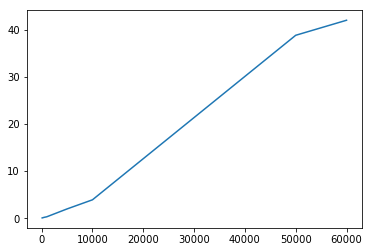

In [110]:
plt.plot(SCALES, runtimes)

#### As expected its basically a linear scaling with N. Lets try to do better by using PyWren.
Our strategy will be to use PyWren to map over (training point, testing point) pairs (in a blockwise fashion), and generate the distance matrix in a sharded form. Then we can launch another PyWren job to extract the nearest neighbors. 

In [22]:
# create an "empty" ShardedMatrix on S3 (we will fill this Matrix in with pywren)
D_sharded = matrix.ShardedMatrix("D", shape=(X_train.shape[0], X_test.shape[0]), shard_sizes=[4000,4000], bucket=DEFAULT_BUCKET)

def compute_local_nearest_neighbor_distance_matrix(block_pair, X_train_sharded, X_test_sharded, D_sharded):
    block0,block1 = block_pair
    # compute a distance matrix block
    X_train_block = X_train_sharded.get_block(block0, 0)
    X_test_block = X_test_sharded.get_block(block1, 0)
    train_norms = np.linalg.norm(X_train_block, axis=1)[:, np.newaxis] ** 2
    test_norms = np.linalg.norm(X_test_block, axis=1)[np.newaxis, :] ** 2
    D_block = train_norms + -2*X_train_block.dot(X_test_block.T)+ test_norms
    D_sharded.put_block(block0, block1, D_block)
    return 0 

In [23]:
pywren_distance_function = lambda bidx: compute_local_nearest_neighbor_distance_matrix(bidx, X_train_sharded, X_test_sharded, D_sharded)

In [24]:
%time futures = pwex.map(pywren_distance_function, D_sharded.block_idxs_not_exist)

CPU times: user 1.37 s, sys: 174 ms, total: 1.55 s
Wall time: 6.23 s


In [27]:
D_sharded.block_idxs_not_exist

[]

In [39]:
def find_argmin(block_pair, D_sharded):
    D_block = D_sharded.get_block(*block_pair)
    offset = block_pair[0]*D_sharded.shard_sizes[0] 
    return (block_pair[1], offset + np.argmin(D_block, axis=0))

In [40]:
%time futures = pwex.map(lambda x: find_argmin(x, D_sharded), sorted(D_sharded.block_idxs))

CPU times: user 1.3 s, sys: 177 ms, total: 1.48 s
Wall time: 2.58 s


In [41]:
%time pywren.wait(futures)

CPU times: user 1.45 s, sys: 170 ms, total: 1.62 s
Wall time: 21.2 s


([<pywren.future.ResponseFuture at 0x118403710>,
 [])

In [47]:
results = [f.result() for f in futures]

In [65]:
a = results[:4]

In [70]:
for key, group in itertools.groupby(results, lambda x: x[0]):
    for thing in group:
        print(key, thing)

0 (0, array([2857, 1328, 3227, ..., 1899, 2541, 2978]))
1 (1, array([1986, 1986, 3092, ..., 3412, 1933, 3412]))
2 (2, array([3412, 3412, 3412, ..., 2952, 1614, 3561]))
0 (0, array([5849, 4922, 5589, ..., 4557, 5198, 6934]))
1 (1, array([5734, 4803, 6972, ..., 7362, 5954, 5731]))
2 (2, array([7206, 5954, 6921, ..., 7249, 4239, 5792]))
0 (0, array([ 9375,  9821,  9875, ..., 11660,  9483,  9483]))
1 (1, array([ 9801,  9476, 11477, ..., 10411, 10310, 10310]))
2 (2, array([10411,  9541, 10310, ..., 10310, 10310, 10310]))
0 (0, array([14454, 15977, 14817, ..., 14871, 12731, 15212]))
1 (1, array([15081, 14434, 15789, ..., 12516, 14794, 15370]))
2 (2, array([14339, 14794, 12248, ..., 15835, 14310, 12818]))
0 (0, array([18812, 16354, 16343, ..., 18719, 19541, 18947]))
1 (1, array([18902, 19057, 19735, ..., 19434, 19815, 18887]))
2 (2, array([16793, 18824, 18887, ..., 19508, 19528, 16346]))
0 (0, array([21106, 20463, 23168, ..., 21810, 21667, 21046]))
1 (1, array([21530, 23862, 22137, ..., 22151